In [1]:
!pip install CatBoost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


# 라이브러리

In [2]:
!pip install scikit-posthocs

In [3]:
import time
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro, levene, kruskal
import scikit_posthocs as sp
from datetime import timedelta
import time

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

# 데이터 로드

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 데이터 로드
PATH = '/content/drive/MyDrive/Colab Notebooks/Multicampus-8/4_머신러닝_딥러닝/프로젝트_회귀'
train = pd.read_csv(PATH+'/data/train.csv')
test = pd.read_csv(PATH+'/data/test.csv')

# 데이터 확인
train=train.drop('id',axis=1)
target ='exam_score'

# EDA - 분포 확인

In [ ]:
train.shape, test.shape

In [ ]:
train.isnull().sum()

## 수치형 + target

In [ ]:
train.describe()

In [7]:
n_samples = 5000
def plot_outlier_analysis(df, column_name):
    fig = px.box(df, y=column_name, points="all",
                 title=f"Outlier Analysis: {column_name}",
                 notched=True, # 중앙값 오목하게(notched)
    )

    fig.update_layout(
        xaxis_title="Dataset",
        yaxis_title=column_name,
        width=700,
        height=500
    )
    fig.show()

# 3. 모든 수치형 변수에 대한 종합 Boxplot
def plot_multi_box(df):
    target_cols = df.select_dtypes(include=np.number).columns.tolist()
    fig = go.Figure()
    for col in target_cols:
        fig.add_trace(go.Box(y=df[col], name=col, boxpoints='outliers'))

    fig.update_layout(
        title="수치형",
        showlegend=False
    )
    fig.show()

# 실행
plot_outlier_analysis(train.sample(n=n_samples), 'exam_score')
plot_multi_box(train.sample(n=n_samples))

## 범주형

In [ ]:
train.describe(include=object)

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,630000,630000,630000,630000,630000,630000,630000
unique,3,7,2,3,5,3,3
top,other,b.tech,yes,poor,coaching,medium,moderate
freq,211097,131236,579423,213675,131697,214082,353982


In [8]:
def plot_categorical_distributions(df, target_cols):

    # 2x2 서브플롯 생성
    fig = make_subplots(
        rows = len(target_cols)//2 +1, cols=2,
        subplot_titles=target_cols
    )

    for i, col in enumerate(target_cols):
        # 행(row)과 열(col) 계산 (1부터 시작)
        row = i // 2 + 1
        col_idx = i % 2 + 1

        counts = df[col].value_counts()

        fig.add_trace(
            go.Bar(
                x=counts.index,
                y=counts.values,
                name=col,
                # marker_color='royalblue'
            ),
            row=row, col=col_idx
        )

    # 레이아웃 수정
    fig.update_layout(
        height=1000,
        width=800,
        title_text="Categorical Feature Distributions",
        showlegend=False
    )
    fig.show()

target_cols = train.select_dtypes(exclude=np.number).columns.tolist()
plot_categorical_distributions(train,target_cols)

# EDA - 상관분석(num+ord)
- 다중공선성 없음


In [9]:
num_cols = train.select_dtypes(include = [np.number]).columns.to_list()
ord_cols = ['sleep_quality','facility_rating','exam_difficulty']

ord_cats = [['poor','average','good'],
               ['low','medium','high'],
               ['easy','moderate','hard']]

In [11]:
def ord_label_enc(df, ord_cols, ord_cats):
    eda_df = df.copy()
    for col, cats in zip(ord_cols, ord_cats):
        mapping = {val: i for i, val in enumerate(cats)}
        eda_df[col] = eda_df[col].map(mapping)
    return eda_df

eda_df = ord_label_enc(train,ord_cols, ord_cats)
corr = eda_df.select_dtypes(include=[np.number]).corr()

fig = px.imshow(corr, text_auto=True,
                title="Correlation Heatmap: Checking for Redundant Features",
                color_continuous_scale='gnbu', aspect="auto")
fig.show()

In [12]:
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
)
corr_pairs.columns = ['var1', 'var2', 'corr']

# strong = corr_pairs[corr_pairs['corr'].abs() >= 0.7]
# medium = corr_pairs[(corr_pairs['corr'].abs() >= 0.4) & (corr_pairs['corr'].abs() < 0.7)]
# weak = corr_pairs[(corr_pairs['corr'].abs() >= 0.2) & (corr_pairs['corr'].abs() < 0.4)]

# display(strong)
# display(medium)
# display(weak)
corr_pairs.nlargest(10, ['corr'])

,var1,var2,corr
12,study_hours,exam_score,0.762267
17,class_attendance,exam_score,0.360954
24,sleep_quality,exam_score,0.236895
26,facility_rating,exam_score,0.188159
21,sleep_hours,exam_score,0.167410
7,study_hours,class_attendance,0.087617
9,study_hours,sleep_quality,0.051590
8,study_hours,sleep_hours,0.042491
10,study_hours,facility_rating,0.030338
15,class_attendance,facility_rating,0.030138


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
num_cols = [col for col in eda_df.select_dtypes(include=np.number).columns if col != 'exam_score']

def calculate_vif(df, target_cols):

    X = df[target_cols].copy()
    # 2. VIF는 상수항이 있어야 정확하므로 추가 (상수항이 없으면 VIF가 과하게 높게 나옴)
    X = add_constant(X)

    # 3. VIF 계산 결과를 담을 리스트 생성
    vif_list = []
    for i in range(len(X.columns)):
        vif_val = variance_inflation_factor(X.values, i)
        vif_list.append(vif_val)

    # 4. 결과 DataFrame 생성
    vif_df = pd.DataFrame({'feature': X.columns, 'VIF': vif_list})

    # 'const' (상수항) 행은 제외하고 반환 (선택 사항)
    return vif_df[vif_df['feature'] != 'const']

result = calculate_vif(eda_df, num_cols)
print(result)

            feature       VIF
1               age  1.000255
2       study_hours  1.012943
3  class_attendance  1.009209
4       sleep_hours  1.003120
5     sleep_quality  1.003310
6   facility_rating  1.001779
7   exam_difficulty  1.000294


In [14]:
num_cols_eda=eda_df.select_dtypes(include=np.number).drop('exam_score', axis=1).columns.tolist()
num_cols_eda

['age',
 'study_hours',
 'class_attendance',
 'sleep_hours',
 'sleep_quality',
 'facility_rating',
 'exam_difficulty']

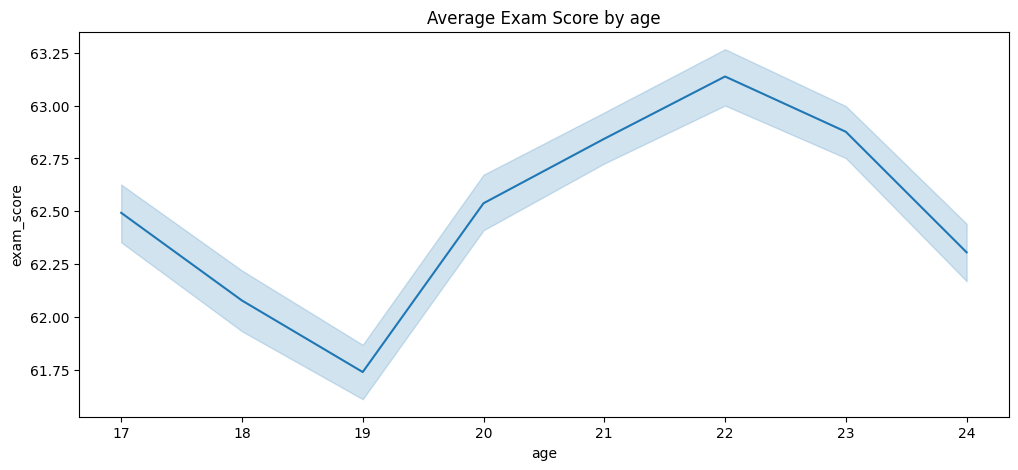

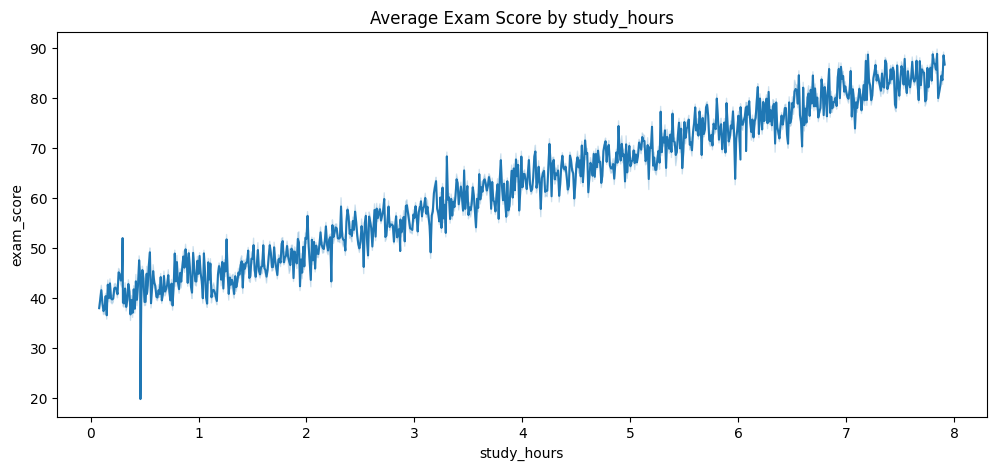

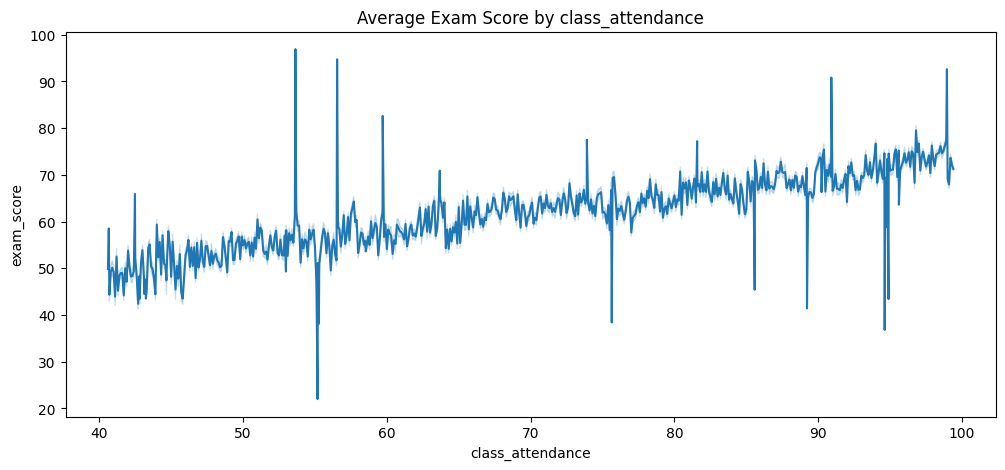

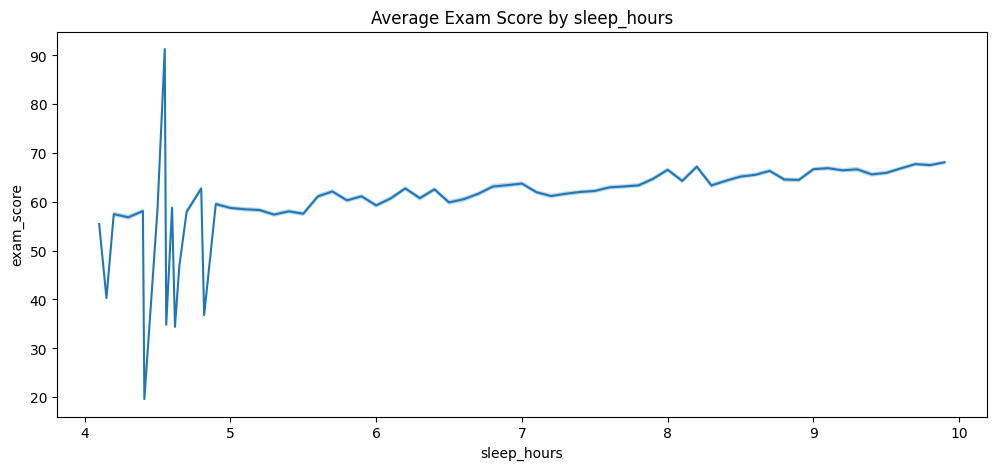

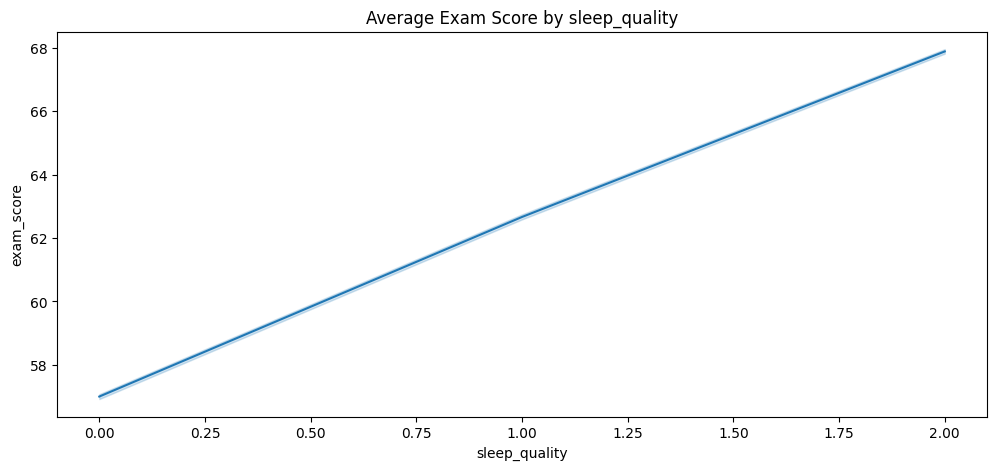

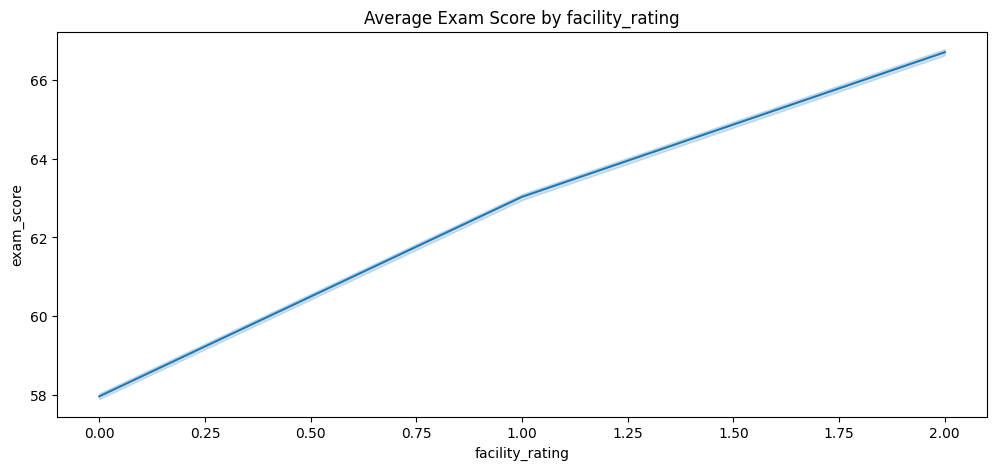

KeyboardInterrupt: 

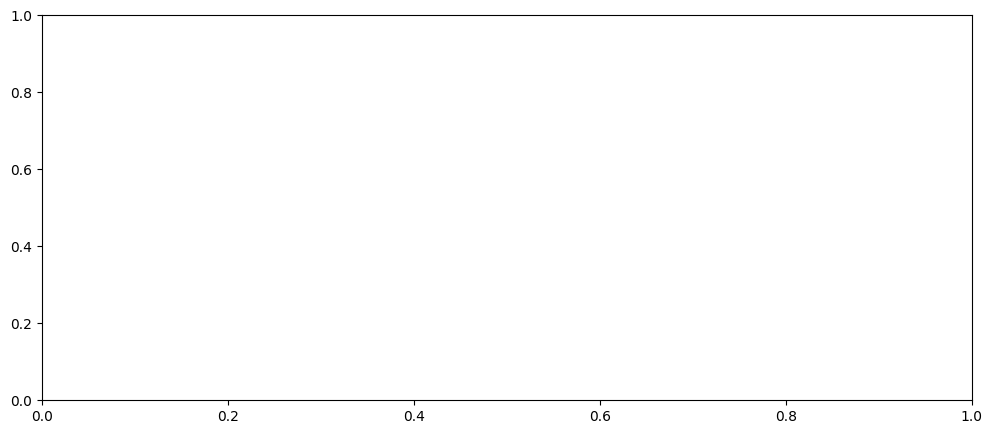

In [15]:
for col in num_cols_eda:
    age_sc = train.groupby('age')['exam_score'].median()
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=eda_df, x=col, y='exam_score')
    plt.title(f'Average Exam Score by {col}')
    plt.show()

####EDA결과 : scaling, encoding외 전처리 필요 x
- age는 경향성 있으므로 'age_cat'추가 고려

# 통계분석

In [16]:
def age_grouping(age):
    if age <= 19: return 'low'  # 19세까지 하락
    elif age <= 22: return 'middle'   # 22세 정점까지 상승
    else: return 'high'          # 24세까지 하락

# eda_df['age_ord'] = eda_df['age'].apply(age_grouping)
train['age_ord'] = train['age'].apply(age_grouping)
test['age_ord'] = test['age'].apply(age_grouping)

In [17]:
ord_cols = ['sleep_quality','facility_rating','exam_difficulty']
ord_cats = [['poor','average','good'],
               ['low','medium','high'],
               ['easy','moderate','hard']]
eda_df = ord_label_enc(train,ord_cols, ord_cats)

num_cols_eda=eda_df.select_dtypes(include=np.number).drop('exam_score', axis=1).columns.tolist()
num_cols_eda

['age',
 'study_hours',
 'class_attendance',
 'sleep_hours',
 'sleep_quality',
 'facility_rating',
 'exam_difficulty']

## numeric(상관분석,

### 상관분석(num, ord)
- `study_hours`, `class_attendance`, `sleep_quality` 유의(0.2이상)

> 인용구 추가



In [18]:
# target과 상관관계확인

pearson_corr = eda_df[num_cols_eda + ['exam_score']].corr(method='pearson')['exam_score']
spearman_corr = eda_df[num_cols_eda + ['exam_score']].corr(method='spearman')['exam_score']

corr_df = pd.DataFrame({
    'Feature': num_cols_eda,
    'Pearson': pearson_corr.drop('exam_score').values,
    'Spearman': spearman_corr.drop('exam_score').values
})


plot_df = corr_df.melt(id_vars='Feature',
                       value_vars=['Pearson', 'Spearman'],
                       var_name='Method',
                       value_name='Correlation')

fig = px.bar(
    plot_df,
    x='Correlation',
    y='Feature',
    color='Method',
    barmode='group',
    orientation='h',
    title='<b>Pearson & Spearman Correlation with Exam Score</b>',
    color_discrete_map={
        'Pearson': '#f67075',
        'Spearman': '#70aaf6'
    }
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    height=700,

    paper_bgcolor='#f9f9f9', # 전체 배경
    plot_bgcolor='#f9f9f9',   # 차트 안쪽 배경

    # 폰트 설정 (가독성 향상)
    font=dict(family="Arial", size=12, color="#333333"),

    # 여백 조절
    margin=dict(l=50, r=50, t=80, b=50)
)


threshold = 0.2  # 원하는 기준

fig.add_shape(
    type="line",
    x0=threshold, x1=threshold,
    y0=-0.5, y1=len(plot_df['Feature'].unique()) - 0.5,
    line=dict(color="black", width=2, dash="dash")
)

fig.show()


In [ ]:
corr_df.sort_values(by='Spearman', ascending=False)

### 효과크기

In [19]:
def test_numeric_features_comprehensive(df, num_cols, target_col='exam_score'):
    results = []
    print(f"### [Step 1] Statistical Analysis with Effect Size (Target: {target_col}) ###\n")

    for col in num_cols:
        # 1. Pearson Correlation & R-Squared
        corr, p_val = stats.pearsonr(df[col], df[target_col])
        abs_corr = abs(corr)
        r_squared = corr ** 2

        # 2. Cohen's d (Binary comparison based on Median)
        # Reference: Haslwanter (2016) - Standardized mean difference
        median_val = df[col].median()
        high_grp = df[df[col] > median_val][target_col]
        low_grp = df[df[col] <= median_val][target_col]

        n1, n2 = len(high_grp), len(low_grp)
        if n1 > 1 and n2 > 1:
            pooled_std = np.sqrt(((n1 - 1) * high_grp.var() + (n2 - 1) * low_grp.var()) / (n1 + n2 - 2))
            cohens_d = (high_grp.mean() - low_grp.mean()) / pooled_std if pooled_std != 0 else 0
        else:
            cohens_d = 0

        # 3. Eta-squared (η²) via ANOVA
        # Reference: Unpingco (2016) - Proportion of variance explained
        formula = f"{target_col} ~ {col}"
        model = ols(formula, data=df).fit()
        anova_table = anova_lm(model)
        eta_sq = anova_table['sum_sq'][col] / (anova_table['sum_sq'][col] + anova_table['sum_sq']['Residual'])

        # Effect Size Interpretation
        if abs_corr < 0.1: effect_size = "Negligible"
        elif abs_corr < 0.3: effect_size = "Small"
        elif abs_corr < 0.5: effect_size = "Medium"
        else: effect_size = "Large"

        results.append({
            'Variable': col,
            'Cohen_d': f"{cohens_d:.3f}",
            'Eta_Sq': f"{eta_sq:.4f}",
            'Effect_Size': effect_size
        })

    results_df = pd.DataFrame(results)
    # Convert back to float for sorting (Modern Pandas 2.3.x compatible)
    results_df['abs_d'] = results_df['Cohen_d'].astype(float).abs()
    display(results_df.sort_values(by='abs_d', ascending=False).drop(columns=['abs_d']))

    print("\n### [Step 2] Mutual Information (Non-linear Importance) ###")
    mi_scores = mutual_info_regression(df[num_cols], df[target_col])
    mi_series = pd.Series(mi_scores, name="MI Score", index=num_cols).sort_values(ascending=False)
    print(mi_series)

    return results_df, mi_series

# 실행 (eda_df와 num_cols가 정의되어 있어야 합니다)
num_test_results, mi_scores = test_numeric_features_comprehensive(eda_df, num_cols_eda)

### [Step 1] Statistical Analysis with Effect Size (Target: exam_score) ###



,Variable,Cohen_d,Eta_Sq,Effect_Size
1,study_hours,1.784,0.5811,Large
2,class_attendance,0.630,0.1303,Medium
4,sleep_quality,0.439,0.0561,Small
5,facility_rating,0.332,0.0354,Small
3,sleep_hours,0.283,0.0280,Small
0,age,0.022,0.0001,Negligible
6,exam_difficulty,0.010,0.0001,Negligible



### [Step 2] Mutual Information (Non-linear Importance) ###
study_hours         0.912322
class_attendance    0.301538
sleep_hours         0.071971
sleep_quality       0.035876
facility_rating     0.029880
age                 0.012942
exam_difficulty     0.007674
Name: MI Score, dtype: float64


## categorical (Kruskal-Wallis)
- 변수들이 정규성을 만족하지 않아서 anova대신 kruskal-wallis

In [20]:
cat_cols = ['internet_access',
 'age_ord',
 'gender',
 'study_method',
 'course']

In [21]:
rows = []

for col in cat_cols:
    for g in train[col].unique():
        scores = train[train[col] == g]['exam_score']
        stat, p = shapiro(scores)
        rows.append({
            'variable': col,
            'group': g,
            'pvalue': p,
            'n': len(scores)
        })

cat_df = pd.DataFrame(rows)
cat_df[cat_df['pvalue'] < 0.05]

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50577.

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 579423.

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 242312.

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 227705.

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 159983.

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py

,variable,group,pvalue,n
0,internet_access,no,3.707570e-53,50577
1,internet_access,yes,4.029185e-83,579423
2,age_ord,middle,4.430024e-71,242312
3,age_ord,low,2.561506e-72,227705
4,age_ord,high,9.936989e-68,159983
5,gender,female,1.118482e-69,208310
6,gender,other,5.906200e-73,211097
7,gender,male,2.090862e-68,210593
8,study_method,online videos,2.408149e-59,121077
9,study_method,self-study,2.870432e-61,131131


In [22]:
def kruskal_effect_size(df, cols, target_col):
    rows= []
    for group_col in cols:
        groups = [df[df[group_col] == g][target_col] for g in df[group_col].unique()]

        # Kruskal-Wallis
        H, p = kruskal(*groups)

        # 파라미터
        k = len(groups)
        n = len(df)

        # 효과 크기 계산
        eta2 = (H - k + 1) / (n - k)
        epsilon2 = (H - k + 1) / n

        rows.append({
            'var': group_col,
            'H_stat': H,
            'p_value': p,
            'eta_squared': eta2,
            'epsilon_squared': epsilon2
        })
    result_df = pd.DataFrame(rows)
    return round(result_df, 5).sort_values(by = 'eta_squared', ascending = False)
# 예시 실행
result = kruskal_effect_size(train, cols=cat_cols, target_col='exam_score')
result


,var,H_stat,p_value,eta_squared,epsilon_squared
3,study_method,29548.41980,0.00000,0.04690,0.04690
4,course,199.28399,0.00000,0.00031,0.00031
1,age_ord,111.95344,0.00000,0.00017,0.00017
2,gender,81.53952,0.00000,0.00013,0.00013
0,internet_access,4.91534,0.02662,0.00001,0.00001


###사후분석(dunn)

In [ ]:
train.columns

In [ ]:
posthoc = sp.posthoc_dunn(train, val_col='exam_score', group_col='study_method', p_adjust='bonferroni')

# 2. 결과 출력 (행렬 형태의 p-value)
print(round(posthoc,5))

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='study_method', y='exam_score', data=train, inner="quartile", palette="muted")
plt.title("Score Distribution by study method")
plt.show()

In [ ]:
# 등수비교
train['rank'] = train['exam_score'].rank()/len(train)
rank_mean = train.groupby('study_method')['rank'].mean().sort_values(ascending=False)
print(rank_mean)
train = train.drop('rank',axis=1)

In [ ]:
train['rank'] = train['exam_score'].rank(ascending=False)/len(train)
rank_mean = train.groupby('study_method')['rank'].median().sort_values(ascending=False)
print(rank_mean)
train = train.drop('rank',axis=1)

In [ ]:
import matplotlib.patches as patches
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 기준
# 1. 데이터 설정 (사용자님이 구한 median rank 값)
methods = ['Coaching', 'Mixed', 'Group Study', 'Online Videos', 'Self-study']
ranks = [0.626, 0.557, 0.464, 0.441, 0.397] # 1에 가까울수록 상위권(꼭짓점 근처)
colors = ['#FF4B4B', '#FF8C00', '#FFD700', '#1E90FF', '#808080']

fig, ax = plt.subplots(figsize=(8, 10))

# 2. 피라미드(삼각형) 그리기
triangle = plt.Polygon([[0, 0], [1, 0], [0.5, 1]], closed=True,
                       edgecolor='black', facecolor='#f9f9f9', linewidth=2)
ax.add_patch(triangle)

# 3. 각 방법별 중앙값 선 표시
for method, rank, color in zip(methods, ranks, colors):
    # 삼각형의 닮음비를 이용해 높이(rank)에 따른 선의 너비 계산
    width = 1 - rank
    x_start = 0.5 - (width / 2)
    x_end = 0.5 + (width / 2)

    # 선 긋기
    ax.hlines(y=rank, xmin=x_start, xmax=x_end, color=color, linewidth=3, label=f'{method}')

    # 텍스트 라벨 (상위 % 환산)
    top_percent = (1 - rank) * 100
    ax.text(x_end + 0.02, rank, f'← {method} (TOP {top_percent:.1f}%)',
            va='center', fontweight='bold', color=color)

# 4. 축 및 가이드라인 설정
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.05, 1.1)
ax.axis('off') # 불필요한 축 제거

# 꼭짓점과 바닥 라벨
ax.text(0.5, 1.05, 'TOP 1%', ha='center', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
train.columns

## welch's ANOVA

In [23]:
! pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.3 MB/s eta 0:00:00


In [24]:
import pingouin as pg
# Welch's ANOVA 실행
anova_results = []

for col in cat_cols:
    res = pg.welch_anova(dv='exam_score', between=col, data=train)
    res['variable'] = col  # 어떤 변수의 결과인지 표시
    anova_results.append(res)

# 결과를 하나로 합쳐서 보기
final_res = pd.concat(anova_results, ignore_index=True)
print(round(final_res[['variable', 'F', 'p-unc', 'np2']],5))

          variable           F    p-unc      np2
0  internet_access     0.12172  0.72717  0.00000
1          age_ord    91.73659  0.00000  0.00029
2           gender    55.53870  0.00000  0.00018
3     study_method  8271.34401  0.00000  0.05009
4           course    32.12757  0.00000  0.00031


## mutual_info_Score

In [25]:
def calculate_combined_mi(df = train, target_col='exam_score'):
    temp_df = df.copy()
    y = temp_df[target_col]
    X = temp_df.drop(columns=[target_col])

    # 2. 범주형 변수 식별 및 인코딩
    # discrete_features 리스트 생성 (True: 범주형, False: 수치형)
    discrete_features = []

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category' or X[col].dtype == 'bool':
            # 문자열을 숫자로 변환 (Label Encoding)
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            discrete_features.append(True)
        else:
            discrete_features.append(False)


    # 3. MI 계산 (discrete_features 인자로 범주형임을 명시)
    # Reference: Unpingco (2016) - Information theoretic metrics
    mi_scores = mutual_info_regression(
        X, y,
        discrete_features=discrete_features,
        random_state=42
    )

    # 4. 결과 정리
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'MI_Score': mi_scores
    }).sort_values(by='MI_Score', ascending=False)

    return mi_df

# 실행
try:
    combined_mi = calculate_combined_mi(train)
    display(combined_mi)
except Exception as e:
    print(f"Error: {e}")

,Feature,MI_Score
3,study_hours,0.911732
4,class_attendance,0.301853
6,sleep_hours,0.073130
8,study_method,0.042237
7,sleep_quality,0.037008
9,facility_rating,0.030574
2,course,0.017901
0,age,0.013890
10,exam_difficulty,0.006966
11,age_ord,0.004584


##변수선정

In [ ]:
train.columns

Index(['age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score', 'age_ord'],
      dtype='object')

In [ ]:
y = train.pop('exam_score')
x_tr, x_val, y_tr, y_val = train_test_split(train, y, test_size=0.2, random_state=42)
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((504000, 12), (126000, 12), (504000,), (126000,))

In [ ]:
x_sam, _, y_sam, _ = train_test_split(x_tr, y_tr, train_size=0.2, random_state=42)

def experiment_feature_selection_xgb(X = x_tr,y = y_sam, target_col='exam_score'):
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

    # 2. Train/Test 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. XGBoost 모델 학습 (변수 중요도 추출용)
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        importance_type='gain' # 'weight', 'cover' 중 'gain'이 가장 신뢰도가 높음
    )
    model.fit(X_train, y_train)
    base_preds = model.predict(X_test)
    base_mse = mean_squared_error(y_test, base_preds)
    # 4. 변수 중요도 시각화
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    results = [{
        'Excluded_Feature': 'None (Baseline)',
        'MSE': base_mse,
        'MSE_Diff': 0 # 기준점
    }]

    # plt.figure(figsize=(10, 6))
    # sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    # plt.title('XGBoost Feature Importance (Gain)')
    # plt.show()

    all_features = X_train.columns.tolist()

    for feature in all_features:
        # 해당 변수만 제외한 리스트 생성
        reduced_features = [f for f in all_features if f != feature]

        # 모델 재학습
        model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
        model.fit(X_train[reduced_features], y_train)

        preds = model.predict(X_test[reduced_features])
        mse = mean_squared_error(y_test, preds)

        results.append({
            'Excluded_Feature': feature,
            'MSE': mse,
            'MSE_Diff': mse - base_mse # 양수면 '이 변수가 빠져서 오차가 늘어났다'는 뜻
        })
        print(f"Excluding [{feature}]: MSE = {mse:.4f} (Diff: {mse - base_mse:+.4f})")

    exp_df = pd.DataFrame(results)
    # 차이가 큰 순서(중요한 변수)대로 정렬
    display(exp_df.sort_values(by='MSE_Diff', ascending=False))

    return exp_df


# 실행
experiment_feature_selection_xgb(X = x_sam,y = y_sam, target_col='exam_score')

Excluding [age]: MSE = 78.5426 (Diff: -0.0673)
Excluding [gender]: MSE = 78.6157 (Diff: +0.0058)
Excluding [course]: MSE = 78.5365 (Diff: -0.0734)
Excluding [study_hours]: MSE = 257.7248 (Diff: +179.1149)
Excluding [class_attendance]: MSE = 108.2882 (Diff: +29.6784)
Excluding [internet_access]: MSE = 78.6220 (Diff: +0.0121)
Excluding [sleep_hours]: MSE = 83.7250 (Diff: +5.1151)
Excluding [sleep_quality]: MSE = 91.1681 (Diff: +12.5582)
Excluding [study_method]: MSE = 89.4463 (Diff: +10.8364)
Excluding [facility_rating]: MSE = 87.0406 (Diff: +8.4307)
Excluding [exam_difficulty]: MSE = 78.4609 (Diff: -0.1490)
Excluding [age_ord]: MSE = 78.6178 (Diff: +0.0079)


,Excluded_Feature,MSE,MSE_Diff
4,study_hours,257.724785,179.114891
5,class_attendance,108.288248,29.678353
8,sleep_quality,91.168058,12.558164
9,study_method,89.446273,10.836379
10,facility_rating,87.040614,8.430719
7,sleep_hours,83.725006,5.115112
6,internet_access,78.621999,0.012105
12,age_ord,78.617763,0.007868
2,gender,78.615677,0.005783
0,None (Baseline),78.609894,0.000000


,Excluded_Feature,MSE,MSE_Diff
0,None (Baseline),78.609894,0.000000
1,age,78.542600,-0.067294
2,gender,78.615677,0.005783
3,course,78.536487,-0.073407
4,study_hours,257.724785,179.114891
5,class_attendance,108.288248,29.678353
6,internet_access,78.621999,0.012105
7,sleep_hours,83.725006,5.115112
8,sleep_quality,91.168058,12.558164
9,study_method,89.446273,10.836379


# 머신러닝

## preprocessor

In [ ]:
# 데이터 로드
PATH = '/content/drive/MyDrive/Colab Notebooks/Multicampus-8/4_머신러닝_딥러닝/프로젝트_회귀'
train = pd.read_csv(PATH+'/data/train.csv')
test = pd.read_csv(PATH+'/data/test.csv')

# 데이터 확인
train=train.drop('id',axis=1)
target ='exam_score'

In [ ]:
def age_grouping(age):
    if age <= 19: return 'low'  # 19세까지 하락
    elif age <= 22: return 'middle'   # 22세 정점까지 상승
    else: return 'high'          # 24세까지 하락

# eda_df['age_ord'] = eda_df['age'].apply(age_grouping)
train['age_ord'] = train['age'].apply(age_grouping)
test['age_ord'] = test['age'].apply(age_grouping)

In [ ]:
test_id = test.pop('id')
y = train.pop('exam_score')
train = train.drop(['age','exam_difficulty','course'], axis=1)
test = test.drop(['age','exam_difficulty','course'], axis=1)

train=train.drop('gender', axis=1)
test=test.drop('gender', axis=1)
train.shape, test.shape

((630000, 8), (270000, 8))

In [ ]:
train=train.drop('internet_access', axis=1)
test=test.drop('internet_access', axis=1)

In [ ]:
train.columns

Index(['study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality',
       'study_method', 'facility_rating', 'age_ord'],
      dtype='object')

In [ ]:
num_cols = train.select_dtypes(include = [np.number]).columns.to_list()
ord_cols = ['sleep_quality','facility_rating', 'age_ord']
cat_cols = train.select_dtypes(exclude = [np.number]).columns.to_list()
cat_cols = list(set(cat_cols) - set(ord_cols))

cat_cat_cols = train.select_dtypes(exclude = [np.number]).columns.to_list()
start_idx = len(num_cols)
cat_features_indices = list(range(start_idx, start_idx + len(cat_cat_cols)))
# 1. CatBoost용 전처리기 (범주형은 인코딩 없이 통과)

ord_cat = [['poor','average','good'],
               ['low','medium','high'],
           ['low','middle','high']
           ]

numeric_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='median')),
    ('scaler',StandardScaler())])

categorical_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])

ordinal_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='most_frequent')),
    ('ordinal',OrdinalEncoder(categories=ord_cat, handle_unknown="use_encoded_value", unknown_value=-1))])

preprocessor = ColumnTransformer(
    transformers=[('num',numeric_prep, num_cols),
                  ('cat', categorical_prep, cat_cols),
                  ('ord', ordinal_prep, ord_cols)],
    remainder='drop'
)

cat_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', 'passthrough', cat_cat_cols)  # OneHotEncoder를 쓰지 않음!
])


preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['study_hours', 'class_attendance',
                                  'sleep_hours']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['study_method']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['poor',
                                                                              'average',
                                                                              'good'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high'],
                                                                             ['low',
                                                                              'middle',
                                                                              'high']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['sleep_quality', 'facility_rating',
                                  'age_ord'])])

##train-val 분리

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(train, y, test_size=0.2, random_state=42)
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((504000, 7), (126000, 7), (504000,), (126000,))

## random search - 모델 정의

In [ ]:
SAMPLE_SIZE = 0.1
x_tr_sample, _, y_tr_sample, _ = train_test_split(
    x_tr, y_tr, train_size=SAMPLE_SIZE, random_state=42
)

# 최적화 대상 핵심 모델 3종 정의
lgbm_config={
    "name": "LightGBM",
    'prep': preprocessor,
    "model": LGBMRegressor(random_state=42, device='cpu', verbosity=-1),
    "params": {
        "model__n_estimators": [300, 500, 1000],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [5, 7, 10],
        "model__num_leaves": [31, 63, 127],
        "model__subsample": [0.7, 0.8, 0.9]
    }
}

xgb_config={
    "name": "XGBoost",
    'prep': preprocessor,
    "model": xgb.XGBRegressor(random_state=42, tree_method='hist'), # hist 방식이 대용량에 빠름
    "params": {
        "model__n_estimators": [300, 500, 1000],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [4, 6, 8],
        "model__subsample": [0.7, 0.8, 0.9],
        "model__colsample_bytree": [0.7, 0.8, 0.9]
    }
}

cat_config = {
    "name": "CatBoost",
    'prep': cat_preprocessor,
    "model": CatBoostRegressor(random_state=42, verbose=0, cat_features=cat_features_indices, task_type="CPU"),
    "params": {
        "model__iterations": [500, 1000],
        "model__learning_rate": [0.03, 0.05, 0.1],
        "model__depth": [4, 6, 8]
    }
}

In [ ]:
results = []
best_estimators = {}

def get_rmse_cv(pipe, x, y, n_splits=5):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    # 평균 RMSE와 표준편차를 함께 반환하도록 수정
    return -scores.mean(), scores.std()

def tune_single_model(config, x_data, y_data, results_list, estimator_dict):
    """
    특정 모델 하나만 최적화하고 결과를 저장하는 함수
    """
    if config['name'] in estimator_dict:
        print(f">>> {config['name']}은 이미 학습되었습니다. 건너뜁니다.")
        return

    print(f"\n>>> {config['name']} 최적화 시작...")
    start_time = time.perf_counter()

    try:
        # 파이프라인 구성
        current_prep = config.get('prep', preprocessor)
        pipe = Pipeline([("prep", current_prep), ("model", config['model'])])

        # RandomizedSearchCV (n_jobs=-1로 병렬 처리 유지)
        search = RandomizedSearchCV(
            pipe,
            param_distributions=config['params'],
            n_iter=10,
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        search.fit(x_data, y_data)

        elapsed = time.perf_counter() - start_time
        best_rmse = -search.best_score_

        print(f"{config['name']} 완료! (소요시간: {elapsed/60:.1f}분, 최적 RMSE: {best_rmse:.4f})")

        # 결과 저장
        results_list.append({
            "Model": config['name'],
            "Best_RMSE": best_rmse,
            "Time": str(timedelta(seconds=int(elapsed))),
            "Best_Params": search.best_params_
        })
        estimator_dict[config['name']] = search.best_estimator_

    except Exception as e:
        print(f"!!! {config['name']} 학습 중 에러 발생: {e}")

# --- 실행부 ---

tune_single_model(xgb_config, x_tr_sample, y_tr_sample, results, best_estimators)

# 3. 결과 요약 업데이트
df_tuning = pd.DataFrame(results).sort_values("Best_RMSE")
display(df_tuning)


>>> XGBoost 최적화 시작...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost 완료! (소요시간: 3.4분, 최적 RMSE: 8.8972)


,Model,Best_RMSE,Time,Best_Params
0,XGBoost,8.897215,0:03:26,"{'model__subsample': 0.9, 'model__n_estimators..."


In [ ]:
tune_single_model(lgbm_config, x_tr_sample, y_tr_sample, results, best_estimators)

# 3. 결과 요약 업데이트
df_tuning = pd.DataFrame(results).sort_values("Best_RMSE")
display(df_tuning)


>>> LightGBM 최적화 시작...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
LightGBM 완료! (소요시간: 2.6분, 최적 RMSE: 8.9219)


,Model,Best_RMSE,Time,Best_Params
0,XGBoost,8.897215,0:03:26,"{'model__subsample': 0.9, 'model__n_estimators..."
1,LightGBM,8.921858,0:02:34,"{'model__subsample': 0.7, 'model__num_leaves':..."


In [ ]:
tune_single_model(cat_config, x_tr_sample, y_tr_sample, results, best_estimators)

# 3. 결과 요약 업데이트
df_tuning = pd.DataFrame(results).sort_values("Best_RMSE")
display(df_tuning)


>>> CatBoost 최적화 시작...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
CatBoost 완료! (소요시간: 28.9분, 최적 RMSE: 8.8885)


,Model,Best_RMSE,Time,Best_Params
2,CatBoost,8.888521,0:28:55,"{'model__learning_rate': 0.1, 'model__iteratio..."
0,XGBoost,8.897215,0:03:26,"{'model__subsample': 0.9, 'model__n_estimators..."
1,LightGBM,8.921858,0:02:34,"{'model__subsample': 0.7, 'model__num_leaves':..."


## 앙상블
- rmse가 거의 비슷해서 정교한 가중치 조정x

In [ ]:
# RMSE의 역수를 가중치로 사용 (낮은 RMSE일수록 높은 가중치)

raw_weights = [1/8.827545, 1/8.828255, 1/8.849688]

final_weights = {
    'XGBoost': raw_weights[0] / sum(raw_weights),
    'CatBoost': raw_weights[1] / sum(raw_weights),
    'LightGBM': raw_weights[2] / sum(raw_weights)
}

from sklearn.metrics import mean_squared_error
import numpy as np

# 1. 각 모델의 예측값 확보 (이미 학습된 샘플 데이터 기준)
xgb_val_preds = best_estimators['XGBoost'].predict(x_tr_sample)
cat_val_preds = best_estimators['CatBoost'].predict(x_tr_sample)
lgbm_val_preds = best_estimators['LightGBM'].predict(x_tr_sample)

# 2. 가중치 적용 합산
final_val_preds = (
    final_weights['XGBoost'] * xgb_val_preds +
    final_weights['CatBoost'] * cat_val_preds +
    final_weights['LightGBM'] * lgbm_val_preds
)

# 3. 최종 RMSE 계산
final_rmse = np.sqrt(mean_squared_error(y_tr_sample, final_val_preds))

print(f"🥇 Ensemble Final RMSE: {final_rmse:.4f}")

# 단일 모델들과 비교 출력
print(f"XGBoost 단독: 8.8315")
print(f"CatBoost 단독: 8.8396")
print(f"LightGBM 단독: 8.8523")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🥇 Ensemble Final RMSE: 8.6624
XGBoost 단독: 8.8315
CatBoost 단독: 8.8396
LightGBM 단독: 8.8523


In [ ]:
# [최종 셀] 전체 데이터 학습 및 결과 저장

print(">>> [최종] 63만 건 전체 데이터 학습 시작 (시간이 다소 소요됩니다)...")

# 1. 각 모델을 전체 데이터(X, y)로 재학습
for name, estimator in best_estimators.items():
    print(f"{name} 전체 학습 중...")
    estimator.fit(train, y)

# 2. 테스트 데이터(test_df) 예측
# test_df도 학습 데이터와 동일한 전처리(preprocessor)가 적용되어야 합니다.
print("테스트 데이터 예측 및 가중치 적용 중...")
final_test_preds = np.zeros(len(test))

for name, estimator in best_estimators.items():
    weight = final_weights[name]
    final_test_preds += weight * estimator.predict(test)

# 3. CSV 저장
submission = pd.DataFrame({
    'id': test_id, # 테스트 데이터의 ID 컬럼
    'exam_score': final_test_preds
})

submission.to_csv('final_submission_ensemble.csv', index=False)
print("축하합니다! 'final_submission_ensemble.csv' 파일이 생성되었습니다.")

>>> [최종] 63만 건 전체 데이터 학습 시작 (시간이 다소 소요됩니다)...
XGBoost 전체 학습 중...
LightGBM 전체 학습 중...
CatBoost 전체 학습 중...
테스트 데이터 예측 및 가중치 적용 중...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


축하합니다! 'final_submission_ensemble.csv' 파일이 생성되었습니다.


In [ ]:
import numpy as np


# 1. 개수를 300개로 통일하여 데이터 준비
X_test_sample = x_tr_sample.iloc[:300]

# 각 모델의 전처리 적용
X_proc_xgb = best_estimators['XGBoost'].named_steps['prep'].transform(X_test_sample)
X_proc_cat = best_estimators['CatBoost'].named_steps['prep'].transform(X_test_sample)

# 컬럼명 리스트 확보
xgb_feature_names = best_estimators['XGBoost'].named_steps['prep'].get_feature_names_out()
cat_feature_names = num_cols + cat_cat_cols # CatBoost가 사용한 순서

# 2. 개별 SHAP 값 계산
shap_xgb = shap.TreeExplainer(best_estimators['XGBoost'].named_steps['model']).shap_values(X_proc_xgb)
shap_lgbm = shap.TreeExplainer(best_estimators['LightGBM'].named_steps['model']).shap_values(X_proc_xgb)
shap_cat = shap.TreeExplainer(best_estimators['CatBoost'].named_steps['model']).shap_values(X_proc_cat)

# 3. 앙상블 SHAP 매트릭스 초기화 (XGB 구조 기준)
ensemble_shap_values = np.zeros_like(shap_xgb)

# (1) 구조가 같은 XGB와 LGBM 먼저 가중치 합산
w_xgb = final_weights['XGBoost']
w_lgbm = final_weights['LightGBM']
w_cat = final_weights['CatBoost']

ensemble_shap_values += (w_xgb * shap_xgb) + (w_lgbm * shap_lgbm)

# (2) CatBoost SHAP 값을 XGB 구조에 매핑하여 합산
# Cat의 'gender' 기여도를 XGB의 'gender_Male', 'gender_Female' 등에 각각 더해줌
for i, cat_col in enumerate(cat_feature_names):
    for j, xgb_col in enumerate(xgb_feature_names):
        if cat_col in xgb_col: # 컬럼명이 포함관계라면 (예: 'age' in 'num__age')
            ensemble_shap_matrix[:, j] += w_cat * shap_cat[:, i]

# 4. 시각화
shap.summary_plot(ensemble_shap_values, X_proc_xgb, feature_names=xgb_feature_names)


NameError: name 'ensemble_shap_matrix' is not defined

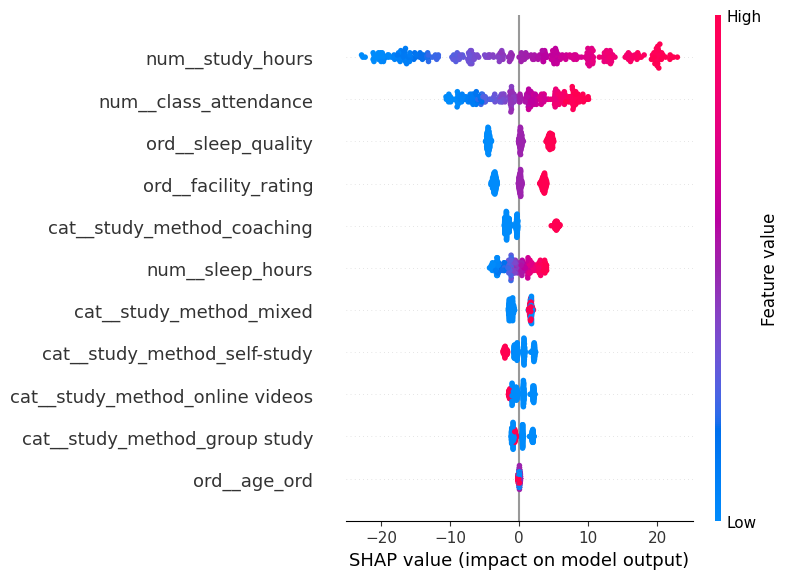

In [ ]:
import numpy as np
import shap

# 1. 개수를 300개로 통일하여 데이터 준비
X_test_sample = x_tr_sample.iloc[:500]

# 각 모델의 전처리 적용
X_proc_xgb = best_estimators['XGBoost'].named_steps['prep'].transform(X_test_sample)
X_proc_cat = best_estimators['CatBoost'].named_steps['prep'].transform(X_test_sample)

# 컬럼명 리스트 확보
xgb_feature_names = best_estimators['XGBoost'].named_steps['prep'].get_feature_names_out()
cat_feature_names = num_cols + cat_cat_cols

# 2. 개별 SHAP 값 계산
shap_xgb = shap.TreeExplainer(best_estimators['XGBoost'].named_steps['model']).shap_values(X_proc_xgb)
shap_lgbm = shap.TreeExplainer(best_estimators['LightGBM'].named_steps['model']).shap_values(X_proc_xgb)
shap_cat = shap.TreeExplainer(best_estimators['CatBoost'].named_steps['model']).shap_values(X_proc_cat)

# 3. 앙상블 SHAP 매트릭스 초기화 (이름 통일)
ensemble_shap_values = np.zeros_like(shap_xgb)

w_xgb = final_weights['XGBoost']
w_lgbm = final_weights['LightGBM']
w_cat = final_weights['CatBoost']

# (1) XGB와 LGBM 가중 합산
ensemble_shap_values += (w_xgb * shap_xgb) + (w_lgbm * shap_lgbm)

# (2) CatBoost SHAP 값을 매핑하여 합산 (변수명 수정 완료)
for i, cat_col in enumerate(cat_feature_names):
    for j, xgb_col in enumerate(xgb_feature_names):
        # 정확한 매핑을 위해 'num__age'와 'age' 등을 비교
        if cat_col in xgb_col:
            ensemble_shap_values[:, j] += w_cat * shap_cat[:, i]

print(ensemble_shap_values)
# 4. 시각화
shap.summary_plot(ensemble_shap_values, X_proc_xgb, feature_names=xgb_feature_names)